# Enunciado Problema 1

## Descripción


En este problema, se presenta un conjunto de datos que contiene información sobre el rendimiento académico de estudiantes universitarios, así como diversos factores que podrían influir en él. El objetivo es construir un modelo de regresión utilizando redes neuronales para predecir el índice de rendimiento académico de los estudiantes basado en las características proporcionadas.


## Dataset


El dataset proporcionado incluye las siguientes variables para cada estudiante:

- Hours Studied: El número total de horas dedicadas al estudio por cada estudiante.
- Previous Scores: Las puntuaciones obtenidas por los estudiantes en exámenes previos.
- Extracurricular Activities: Si el estudiante participa en actividades extracurriculares (Sí o No).
- Sleep Hours: El número promedio de horas de sueño que el estudiante tuvo por día.
- Sample Question Papers Practiced: El número de cuestionarios de muestra que el estudiante practicó.

Además, el dataset incluye la variable objetivo:

- Performance Index: Un índice que representa el rendimiento académico general de cada estudiante, redondeado al entero más cercano. Este índice varía de 10 a 100, donde valores más altos indican un mejor rendimiento.


## Objetivo

Utilizando el dataset proporcionado, el objetivo es construir un modelo de regresión utilizando redes neuronales que pueda predecir con precisión el índice de rendimiento académico de los estudiantes. Se debe entrenar y evaluar el modelo utilizando técnicas adecuadas de validación y métricas de evaluación de regresión.


## Entrega


La entrega debe incluir:
- Código fuente de la solución implementada en Google Colab, que incluya:
    - Análisis previo y preprocesamiento del set de datos.
    - Definición y entrenamiento del modelo.
    - Resultados de la evaluación del modelo, incluyendo métricas de desempeño y visualizaciones relevantes.

Nota: el código debe estar debidamente documentado con comentarios explicativos para que el trabajo sea fácilmente comprensible para otros revisores.

# Resolución

## Configuración

### Entorno

In [137]:
# tools
import zipfile
import os
import random

# processing
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import FixedLocator, FixedFormatter
from IPython.display import clear_output

# deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score
from sklearn.model_selection import train_test_split

In [138]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

### Datos

Los datos se encuentran en un directorio público en Google Drive. De descarga como archivo comprimido y se extrae en el entorno.

In [139]:
# download del archivo
student_performance = '1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc'
!gdown $student_performance

# descomprime el archivo
with zipfile.ZipFile('TP1-1-student_performance.zip', 'r') as zip_ref:
    if not os.path.exists('/content/'):
        os.makedirs('/content/')

    zip_ref.extractall('/content/')

!rm 'TP1-1-student_performance.zip'

Downloading...
From: https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc
To: /content/TP1-1-student_performance.zip
100% 49.7k/49.7k [00:00<00:00, 73.3MB/s]


In [140]:
df = pd.read_csv('/content/Student_Performance.csv')
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [141]:
!rm '/content/Student_Performance.csv'

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [143]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

### Depuración

In [144]:
map_bools = lambda x: 1 if x == 'Yes' else 0

df["Extracurricular Activities"] = df["Extracurricular Activities"].apply(map_bools)

In [145]:
display(df.head(3))
print('\n')
display(df.info())

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  int64  
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(5)
memory usage: 468.9 KB


None

In [146]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

## Análisis

### Primer modelo base

Se pretende generar un modelo básico predefinido con el fin de utilizarlo como base para entender como cambian las metricas de evaluación a medida que se procesa el dataset.

In [147]:
df_train, df_val = train_test_split(df, train_size=0.7, random_state=1)

In [148]:
X_train = df_train.drop('performance_index', axis=1)
y_train = df_train['performance_index']

X_val = df_val.drop('performance_index', axis=1)
y_val = df_val['performance_index']

In [149]:
y_train.head()

2228    66.0
5910    52.0
1950    30.0
2119    83.0
5947    78.0
Name: performance_index, dtype: float64

Se utiliza estandarización de las variables para que todas se mueven en los mismos rangos de valores

In [150]:
scaler = StandardScaler()

# se entrena con datos de entrenamiento, los de validacion solo se transforman
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_val_scaled = scaler.transform(np.array(y_val).reshape(-1, 1))

El modelo base consta de dos capas ocultas, con 32 y 16 neuronas respectivamente

In [151]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.fit(X_train_scaled, y_train_scaled)

# Evaluate the model
loss, mse = model.evaluate(X_val_scaled, y_val_scaled)
y_pred_scaled = model.predict(X_val_scaled)

y_pred = scaler.inverse_transform(y_pred_scaled)
y_val = scaler.inverse_transform(y_val_scaled)

94/94 [==============================] - 0s 1ms/step


In [152]:
r2 = r2_score(y_val, y_pred)

print('Loss:', loss)
print('Mean squared error:', mse)
print('R²:', r2)

Loss: 0.5479004383087158
Mean squared error: 0.5479004383087158
R²: 0.44017179234423975


Las métricas de este modelo son una primera aproximación de un modelo conexionista sobre este dataset.

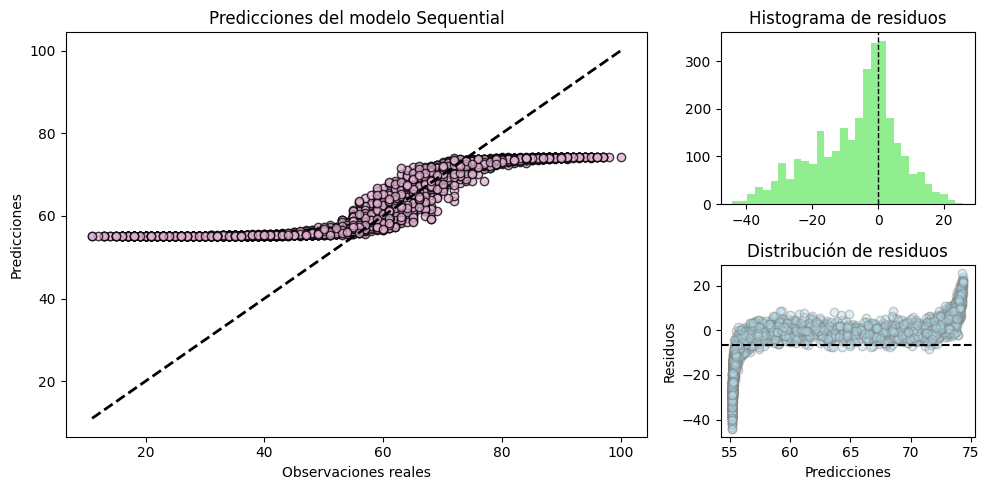

In [154]:
def train_and_evaluate(y_val, preds):
    # Generar los gráficos de residuos y ajuste
    fig = plt.figure(figsize=(10, 5))
    ax0 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((2, 3), (0, 2))
    ax2 = plt.subplot2grid((2, 3), (1, 2))

    # diferencia entre los valores reales y los predsichos
    residuos = y_val - preds

    ax0.scatter(y_val, preds, color='#E1AFD1', alpha=0.75, edgecolor="black")
    ax0.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
    ax0.set_xlabel("Observaciones reales")
    ax0.set_ylabel("Predicciones")
    ax0.set_title(f"Predicciones del modelo {model.__class__.__name__}")

    ax1.hist(residuos, bins=30, color='lightgreen')
    ax1.axvline(x=0, color='k', linestyle='--', linewidth=1)
    ax1.set_title(f"Histograma de residuos")

    ax2.scatter(preds, residuos, color='lightblue', alpha=0.4, edgecolors='gray')
    ax2.axhline(y=residuos.mean(), color='black', linestyle='--')
    ax2.set_xlabel("Predicciones")
    ax2.set_ylabel("Residuos")
    ax2.set_title(f"Distribución de residuos")

    plt.tight_layout()
    plt.show()

train_and_evaluate(y_val, y_pred)

Las métricas demuestran un mal rendimiento del modelo.

De hecho, estos gráficos indican el modelo subestima y sobreestima al mismo tiempo las predicciones. Es decir, predice que todos los alumnos tienen un indice de performance de 60 puntos aproximadamente.

Los gráficos de residuos indican mayormente que se subestiman mas valores.

### Investigación

Se pretende unor en un dataframe ambas partes de los datos de entrenamiento ya escalados para analizar el comportamiento de las variables respecto a la variable objetivo.

In [71]:
df_train_scaled = pd.concat(
                            [
                            pd.DataFrame(X_train_scaled, columns=df_train.drop('performance_index', axis=1).columns),
                            pd.Series(y_train_scaled.flatten(), name='performance_index')
                            ],
                            axis=1
                            )

display(df_train_scaled.head(2))

,hours_studied,previous_scores,extracurricular_activities,sleep_hours,sample_question_papers_practiced,performance_index
0,-0.394381,0.904253,-0.982159,0.275538,0.144458,0.562235
1,-1.166810,0.443852,-0.982159,1.462107,-1.254168,-0.164167


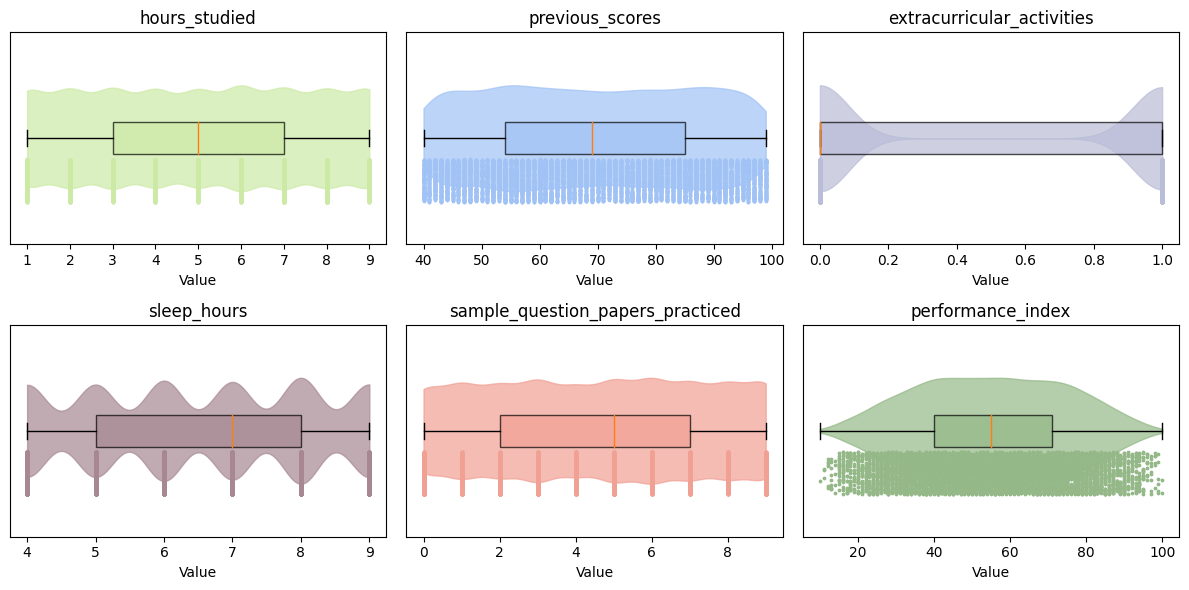

<Figure size 640x480 with 0 Axes>

In [72]:

def plot_boxplot(df, cols: list[str]=[], figsize: tuple = (18, 12), max_cols : int=6 ,
                 scatter:bool=True,
                 violin:bool= True,
                 violin_args: dict = {},
                 boxplot_args: dict = {}):

    default_violin_args = {
         "points": 500,
         "showmeans": False,
         "showextrema": False,
         "showmedians":False,
         "vert":False
    }

    default_boxplot_args = {
        "patch_artist": True,
        "vert":False
    }

    violin_args = {**default_violin_args, **violin_args}
    boxplot_args = {**default_boxplot_args, **boxplot_args}

    cols = cols if cols else list(df.columns)

    # Generate random colors
    random_colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
         for i in range(len(cols))]

    # Convert random colors to pastel colors
    pastel_colors = []
    for color in random_colors:
        r, g, b = tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        pastel_r = (r + 256) // 2
        pastel_g = (g + 256) // 2
        pastel_b = (b + 256) // 2
        pastel_color = '#{:02x}{:02x}{:02x}'.format(pastel_r, pastel_g, pastel_b)
        pastel_colors.append(pastel_color)

    n_rows = int(len(cols)/max_cols) + (len(cols)%max_cols>0)
    n_cols = max_cols

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    plt.figure()

    for idx, column in enumerate(cols):
        ax = axes[idx // n_cols, idx % n_cols]

        bp = ax.boxplot(df[column], **boxplot_args)
        bp['boxes'][0].set_facecolor(pastel_colors[idx])
        bp['boxes'][0].set_alpha(0.7)

        if violin:
            vp = ax.violinplot(df[column], **violin_args)
            vp['bodies'][0].set_color(pastel_colors[idx])
            vp['bodies'][0].set_alpha(0.7)

        if scatter:
            y = np.full(len(df[column]), 0.8) + np.random.uniform(low=-.1, high=.1, size=len(df[column]))
            ax.scatter(df[column], y, s=3, c=pastel_colors[idx])

        ax.set_title(column)
        ax.set_yticks([])
        ax.set_xlabel("Value")

    fig.tight_layout()
    plt.show()

plot_boxplot(df_train, cols=[ c for c in df_train.columns if c != "Class" ], max_cols=3, figsize=(12, 6))


Las ditribuciones de las variables indican que están balanceadas en cada valor, incluso para la variable continua podemos notar una distribución muy pareja.

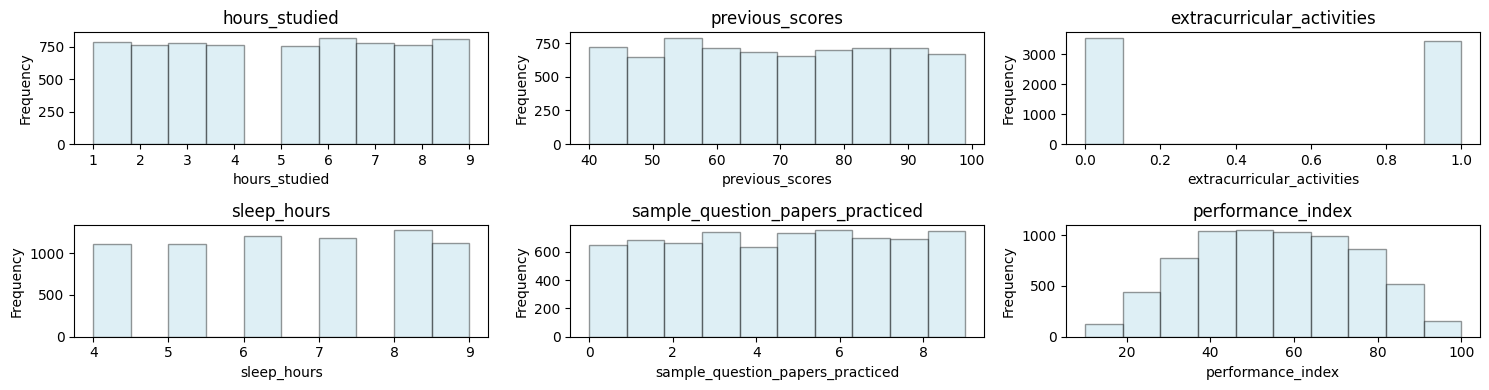

In [155]:
fig, axs = plt.subplots(2, 3, figsize=(15, 4))

axs = axs.flatten()
for i, column in enumerate(df_train.columns):
    axs[i].hist(df_train[column], color='lightblue', edgecolor='black', alpha=0.4)
    axs[i].set_title(column)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


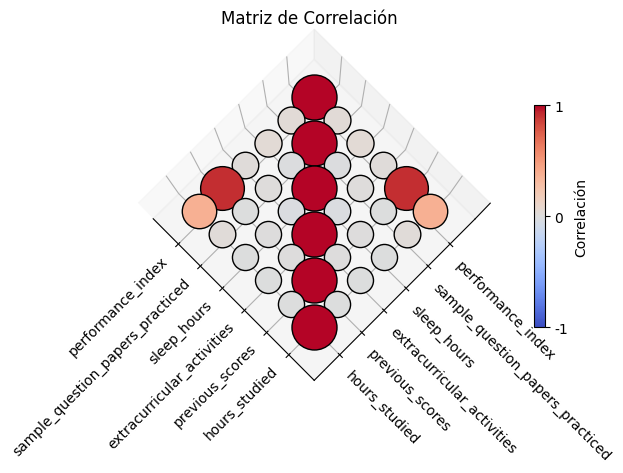

In [74]:
corr = df_train_scaled.corr()

# Obtener las coordenadas (x, y, z) para las esferas
x, y = np.meshgrid(range(corr.shape[0]), range(corr.shape[1]))
z = np.zeros_like(x)

# Obtener los valores de correlación
correlation_values = corr.values.flatten()

# Configurar la figura de matplotlib en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Obtener los tamaños de las esferas de acuerdo a las correlaciones
sizes = np.abs(correlation_values) + 0.5  # Agregar 0.5 para asegurar que las correlaciones nulas sean visibles

# Crear las esferas para cada correlación con una escala de colores
norm = plt.Normalize(-1, 1)
cmap = cm.get_cmap('coolwarm')
colors = cmap(norm(correlation_values))

# Crear las esferas para cada correlación con su color y tamaño correspondientes
for i, (xi, yi, zi) in enumerate(zip(x.flatten(), y.flatten(), z.flatten())):
    correlation = correlation_values[i]
    color = colors[i]
    size = sizes[i]
    ax.scatter(xi, yi, zi, color=color, s=size * 700, edgecolor='black')

# Configurar los límites y etiquetas de los ejes
ax.set_xlim([-1, corr.shape[0]])
ax.set_ylim([-1, corr.shape[1]])

# Ajustar el rango del eje z
z_range = np.nanmax(np.abs(correlation_values))
ax.set_zlim([-z_range, z_range])
ax.set_xticks(range(corr.shape[0]))
ax.set_yticks(range(corr.shape[1]))
ax.set_zticks([])
ax.set_xticklabels(corr.columns, ha='right', va='center', rotation=45, rotation_mode='anchor')
ax.set_yticklabels(corr.columns, ha='right', va='top', rotation=-45, rotation_mode='anchor')

# Ajustar la inclinación del gráfico
ax.view_init(elev=-95, azim=45)

# Agregar la barra de leyenda
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array(correlation_values)
cbar = fig.colorbar(mappable, pad=0.08, shrink=0.6, ticks=[-1, 0, 1])
cbar.set_label('Correlación')
cbar.ax.yaxis.set_major_locator(FixedLocator([-1, 0, 1]))
cbar.ax.yaxis.set_major_formatter(FixedFormatter(['-1', '0', '1']))

# Ajustar la posición de los tick labels en el eje x y eje y
for tick_label_x, tick_label_y in zip(ax.xaxis.get_majorticklabels(), ax.yaxis.get_majorticklabels()):
    tick_label_x.set_bbox({'facecolor': 'white', 'pad': 0.1, 'edgecolor': 'none'})
    tick_label_x.set_horizontalalignment('right')

    tick_label_y.set_bbox({'facecolor': 'white', 'pad': 0.1, 'edgecolor': 'none'})
    tick_label_y.set_horizontalalignment('left')
# agregar titulo
plt.title('Matriz de Correlación')

clear_output()
plt.show()

La matriz de correlación indica que la mayoria de las variables no son linealmente explicativas directamente con la variable objetivo. A excepción de dos de ellas, que indican ser información valiosa para determinar la performance de los estudiantes.

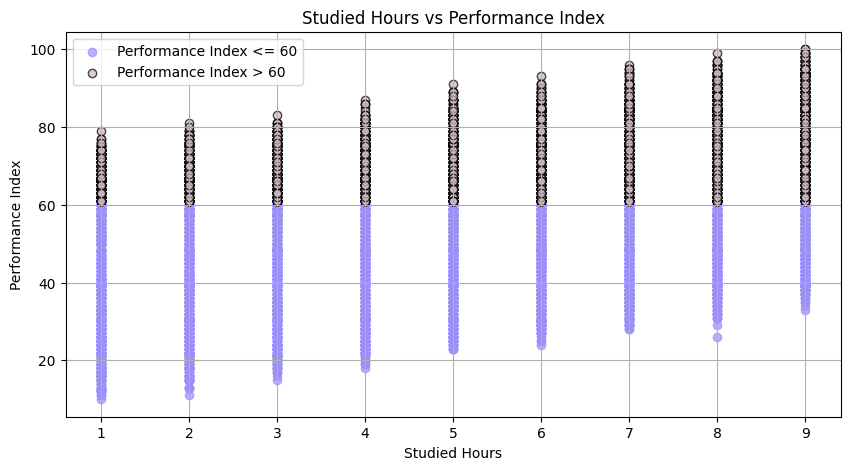

In [75]:
# Generate distinct pastel colors
def generate_pastel_color(high_contrast=True):
    if high_contrast:
        return tuple((np.random.rand(3) * 0.6) + 0.4)  # Generate a high-contrast pastel color
    else:
        return tuple((np.random.rand(3) + 1) / 2)  # Generate a more muted, whitened pastel color

# Scatter plot comparing studied hours with performance index
plt.figure(figsize=(10, 5))

# Plot for students with performance index <= 60
plt.scatter(df_train[df_train['performance_index'] <= 60]['hours_studied'],
            df_train[df_train['performance_index'] <= 60]['performance_index'],
            color=generate_pastel_color(high_contrast=True),
            label='Performance Index <= 60',
            alpha=0.7,
            )

# Plot for students with performance index > 60
plt.scatter(df_train[df_train['performance_index'] > 60]['hours_studied'],
            df_train[df_train['performance_index'] > 60]['performance_index'],
            color=generate_pastel_color(high_contrast=False),
            label='Performance Index > 60',
            alpha=0.7,
            edgecolor='black')

plt.title('Studied Hours vs Performance Index')
plt.xlabel('Studied Hours')
plt.ylabel('Performance Index')
plt.legend()
plt.grid(True)

Como se podía sospechar de la matriz de correlación, podemos notar una relación bastante lineal

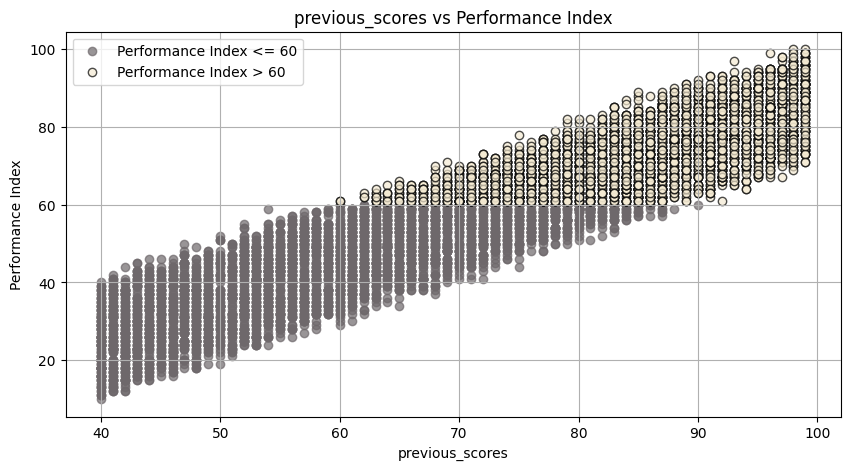

In [76]:
plt.figure(figsize=(10, 5))

plt.scatter(df_train[df_train['performance_index'] <= 60]['previous_scores'],
            df_train[df_train['performance_index'] <= 60]['performance_index'],
            color=generate_pastel_color(high_contrast=True),
            label='Performance Index <= 60',
            alpha=0.7,
            )

plt.scatter(df_train[df_train['performance_index'] > 60]['previous_scores'],
            df_train[df_train['performance_index'] > 60]['performance_index'],
            color=generate_pastel_color(high_contrast=False),
            label='Performance Index > 60',
            alpha=0.7,
            edgecolor='black')

plt.title('previous_scores vs Performance Index')
plt.xlabel('previous_scores')
plt.ylabel('Performance Index')
plt.legend()
plt.grid(True)

Y la variable con mayor correlación lineal muestra una clara tendencia lineal

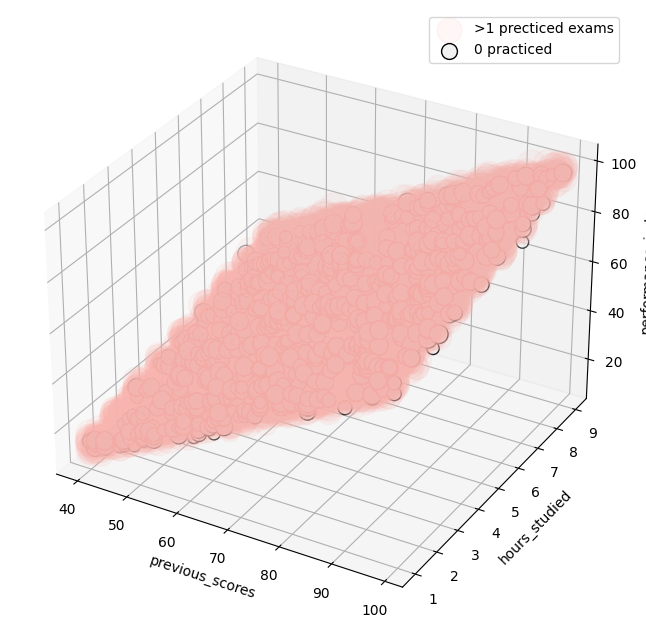

In [77]:

def categorize_class(values):
    if values == 0:
        return '0 practiced'
    else:
        return '>1 precticed exams'

def plot_3d_bubble(df, x_col, y_col, z_col, class_col, size_col):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    df['Category'] = df[class_col].apply(categorize_class)

    categories = df['Category'].unique()
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(categories)))

    for category, color in zip(categories, colors):
        subset = df[df['Category'] == category]
        if category == '0 practiced':
            ax.scatter(subset[x_col], subset[y_col], subset[z_col], c=[color], edgecolor='black', label=category, s=subset[size_col]*20)
        else:
            ax.scatter(subset[x_col], subset[y_col], subset[z_col], c=[color], label=category, s=subset[size_col]*50, alpha=0.1)

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col)
    ax.legend()

    plt.show()

plot_3d_bubble(df_train, 'previous_scores', 'hours_studied', 'performance_index', 'sample_question_papers_practiced', 'sleep_hours')


Este gráfico demuestra una fuerte y casi perfecta correlación lineal entre las tres variables. Se demuestra que mayores scores previos y mayores horas de estudios casi aseguran mayores indices de performance.

Ademas notamos como otras variables como la cantidad de examenes con los que se practicaron casi no tienen relevancia, parece ser indistinto si practican antes o no

## Modelo formal

### Hiper parametros

Tenemos dos variables muy explicativas en el dataset, y las demás no parecen aportar valor para hacer predicciones.

En esta sección se generaran dos modelos, ambos seguiran una arquitectura muy simple, ya que como notamos, las relaciones son totalmente lineales.
Esto implica que un modelo con mas capas/neuronas no es necesario.

Un modelo mas complejo en un dataset simple podría causar sobreajuste.

El primer modelo usará todas las variables como variables para entranimiento

In [109]:
# simple model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(2, activation='relu'),  # One hidden layer with two neurons
    tf.keras.layers.Dense(1)  # Output layer
])

model_1.compile(optimizer='adam', loss='mse', metrics=['mse'])
history_1 = model_1.fit(X_train_scaled, y_train_scaled, epochs=40, batch_size=32, validation_data=(X_val_scaled, y_val_scaled))

loss_1, mse_1 = model_1.evaluate(X_val_scaled, y_val_scaled)
y_pred_1 = model_1.predict(X_val_scaled)


Epoch 1/40
219/219 [==============================] - 2s 6ms/step - loss: 1.0066 - mse: 1.0066 - val_loss: 0.7235 - val_mse: 0.7235
Epoch 2/40
219/219 [==============================] - 1s 4ms/step - loss: 0.6211 - mse: 0.6211 - val_loss: 0.5207 - val_mse: 0.5207
Epoch 3/40
219/219 [==============================] - 1s 3ms/step - loss: 0.4556 - mse: 0.4556 - val_loss: 0.3763 - val_mse: 0.3763
Epoch 4/40
219/219 [==============================] - 1s 2ms/step - loss: 0.3183 - mse: 0.3183 - val_loss: 0.2565 - val_mse: 0.2565
Epoch 5/40
219/219 [==============================] - 0s 2ms/step - loss: 0.2221 - mse: 0.2221 - val_loss: 0.1862 - val_mse: 0.1862
Epoch 6/40
219/219 [==============================] - 1s 3ms/step - loss: 0.1680 - mse: 0.1680 - val_loss: 0.1467 - val_mse: 0.1467
Epoch 7/40
219/219 [==============================] - 1s 2ms/step - loss: 0.1342 - mse: 0.1342 - val_loss: 0.1180 - val_mse: 0.1180
Epoch 8/40
219/219 [==============================] - 0s 2ms/step - loss: 0.

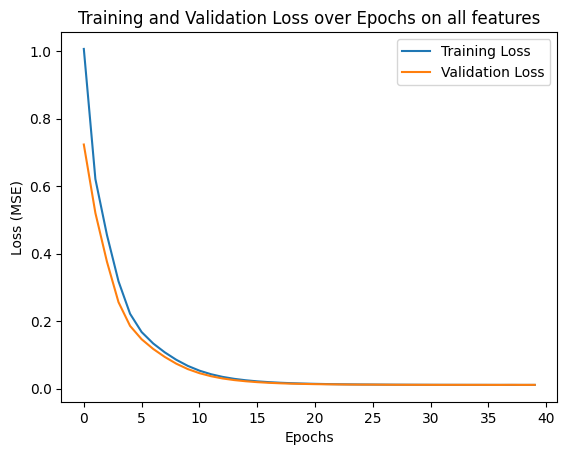

In [110]:
# Extract the loss history from the training and validation data
train_loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

# Plot the training and validation loss over epochs
plt.plot(train_loss_1, label='Training Loss')
plt.plot(val_loss_1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss over Epochs on all features')
plt.legend()
plt.show()


El modelo converge rapidamente y generaliza las predicciones de forma asertada.

El segundo modelo será de la misma arquitectura, pero está vez solo utilizando las variables explicativas relevantes que notamos anteriormente. Esto con la hipetesis de que las demas variables que no aportan valor podrián afectar negativamente al modelo en su entrenamiento.

In [111]:
# Define the relevant columns
relevant_columns = ['hours_studied', 'previous_scores']

# simple model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(pd.DataFrame(X_train_scaled, columns=X_train.columns)[relevant_columns].shape[1],)),
    tf.keras.layers.Dense(2, activation='relu'),  # One hidden layer with two neurons
    tf.keras.layers.Dense(1)  # Output layer
])

model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = model.fit(pd.DataFrame(X_train_scaled, columns=X_train.columns)[relevant_columns], y_train_scaled, epochs=40, batch_size=32, validation_data=(pd.DataFrame(X_val_scaled, columns=X_train.columns)[relevant_columns], y_val_scaled))

loss, mse = model.evaluate(pd.DataFrame(X_val_scaled, columns=X_train.columns)[relevant_columns], y_val_scaled)
y_pred = model.predict(pd.DataFrame(X_val_scaled, columns=X_train.columns)[relevant_columns])


Epoch 1/40
219/219 [==============================] - 2s 5ms/step - loss: 2.4767 - mse: 2.4767 - val_loss: 1.7627 - val_mse: 1.7627
Epoch 2/40
219/219 [==============================] - 1s 3ms/step - loss: 1.5238 - mse: 1.5238 - val_loss: 1.2894 - val_mse: 1.2894
Epoch 3/40
219/219 [==============================] - 1s 2ms/step - loss: 1.2143 - mse: 1.2143 - val_loss: 1.1028 - val_mse: 1.1028
Epoch 4/40
219/219 [==============================] - 1s 2ms/step - loss: 1.0746 - mse: 1.0746 - val_loss: 1.0026 - val_mse: 1.0026
Epoch 5/40
219/219 [==============================] - 1s 3ms/step - loss: 0.9976 - mse: 0.9976 - val_loss: 0.9482 - val_mse: 0.9482
Epoch 6/40
219/219 [==============================] - 1s 3ms/step - loss: 0.9396 - mse: 0.9396 - val_loss: 0.8565 - val_mse: 0.8565
Epoch 7/40
219/219 [==============================] - 1s 3ms/step - loss: 0.7321 - mse: 0.7321 - val_loss: 0.5370 - val_mse: 0.5370
Epoch 8/40
219/219 [==============================] - 2s 7ms/step - loss: 0.

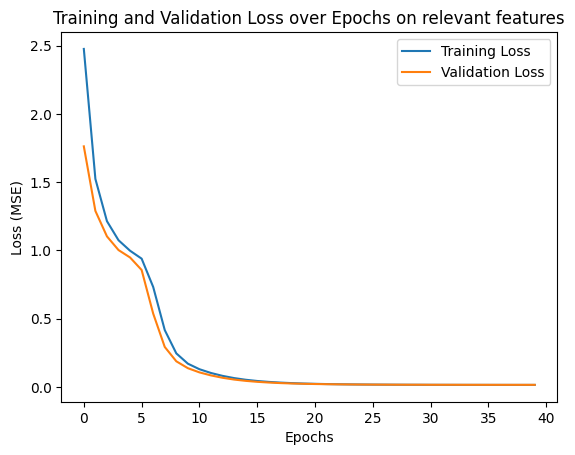

In [112]:
# Extract the loss history from the training and validation data
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss over epochs
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss over Epochs on relevant features')
plt.legend()
plt.show()


Igual que el primer modelo, converge y se estabilizan ambas metricas rapidamente.

### Evaluación

Se construye un dataframe que reune las metricas de ambos modelos para facilitar su comparación

In [115]:

# Metrics for model_1
mae_1 = mean_absolute_error(y_val_scaled, y_pred_1)
rmse_1 = mean_squared_error(y_val_scaled, y_pred_1, squared=False)
mse_1 = mean_squared_error(y_val_scaled, y_pred_1)
r2_1 = r2_score(y_val_scaled, y_pred_1)
explained_var_1 = explained_variance_score(y_val_scaled, y_pred_1)
loss_1 = mse_1  # Assuming loss is the same as MSE for model_1

# Metrics for model_2
mae_2 = mean_absolute_error(y_val_scaled, y_pred)
rmse_2 = mean_squared_error(y_val_scaled, y_pred, squared=False)
mse_2 = mean_squared_error(y_val_scaled, y_pred)
r2_2 = r2_score(y_val_scaled, y_pred)
explained_var_2 = explained_variance_score(y_val_scaled, y_pred)
loss_2 = mse_2  # Assuming loss is the same as MSE for model_2

# Create dictionaries with metrics
metrics_dict = {
    'Loss': [loss_1, loss_2],
    'Mean Squared Error': [mse_1, mse_2],
    'Mean Absolute Error': [mae_1, mae_2],
    'Root Mean Squared Error': [rmse_1, rmse_2],
    'R²': [r2_1, r2_2],
    'Explained Variance Score': [explained_var_1, explained_var_2]
}

metrics_df = pd.DataFrame(metrics_dict, index=['model_1', 'model_2'])
display(metrics_df)


,Loss,Mean Squared Error,Mean Absolute Error,Root Mean Squared Error,R²,Explained Variance Score
model_1,0.011604,0.011604,0.084964,0.107722,0.988143,0.988184
model_2,0.014754,0.014754,0.096328,0.121464,0.984925,0.984930


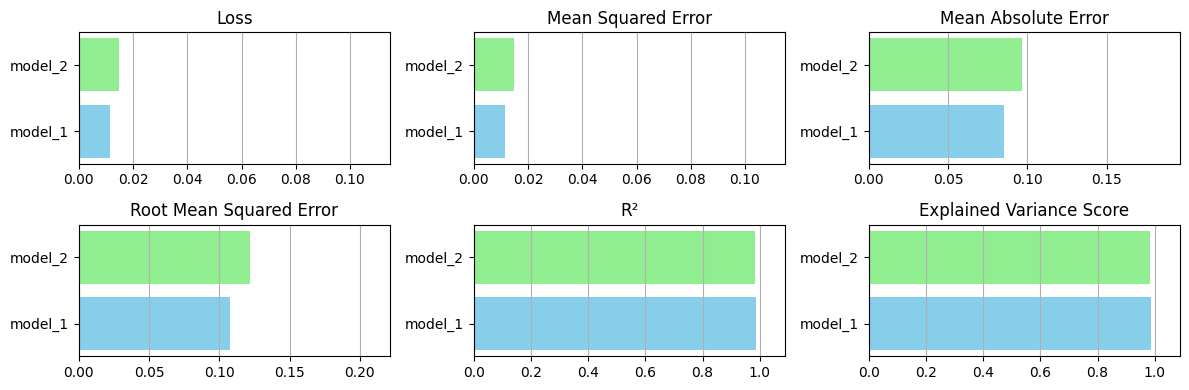

In [135]:
colors = ['skyblue', 'lightgreen']
fig, axs = plt.subplots(2, 3, figsize=(12, 4))

# Iterate over each column
for i, (col_name, col_data) in enumerate(metrics_df.items()):
    # Determine the subplot position
    row_index = i // 3
    col_index = i % 3
    ax = axs[row_index, col_index]

    # Plot horizontal histogram for the current column
    ax.barh(metrics_df.index, col_data, color=colors)
    ax.set_title(col_name)
    ax.set_xlim(0, col_data.max() + 0.1)
    ax.grid(axis='x')

plt.tight_layout()
plt.show()


Estos gráficos nos permiten entender rapidamente que la diferencia es infima, por lo que obtenemos que:

- Las variables que no tenian correlación lineal con la variable objetivo eran irrelevantes para un modelo de red neuronal simple como el presentado
- El modelo que usa todas las variables (modelo 1) rinde ligeramente mejor que el reducido. Como la diferencia es mínima, es más conveniente usar el modelo reducido
- Las metricas en general son muy buenas. Notamos eplicabilidad de casi el 100% y errores muy cercanos a cero, esto significa que un modelo tan simple como el planteado, en este dataset es mas que suficiente

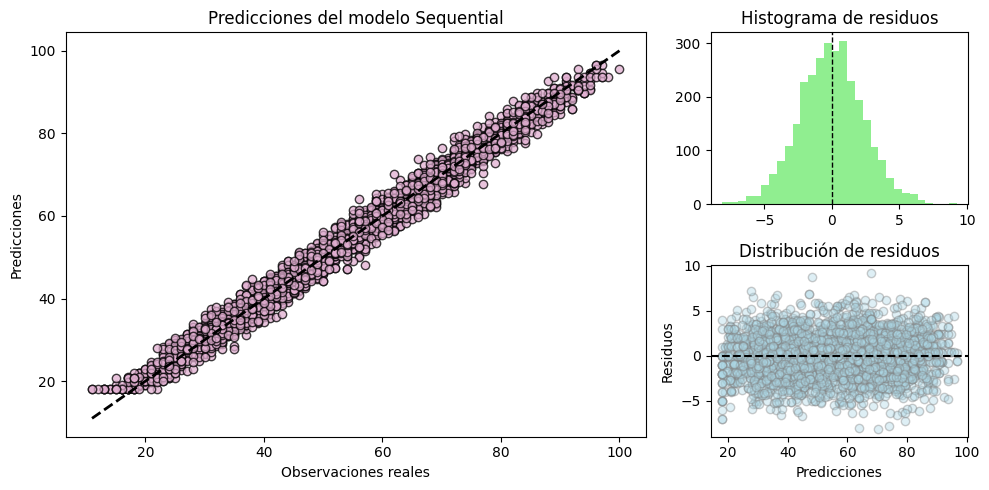

In [116]:
train_and_evaluate(y_val, scaler.inverse_transform(y_pred))

Notemos como el modelo reducido predice con buena certeza los valores y de forma equilibrada.

Los gráficos de residuos son muy parejos, por lo que el modelo generaliza y funciona bien para estimar los indices altos y bajos a la vez.

## Conclusión

El dataset entregado consta de variables con relaciones lineales muy marcadas, y otras variables que no explican o no tienen importancia para determinar el indice de performance.

Mediante análisis descriptivo y pruebas con los modelos de redes neuronales se concluye que no modelo muy básico de un sola capa oculta con dos neuronas de activación lineal son suficientemente buenos para esta tarea, y en un dataset con que podria reducirse solo a dos columnas de variables explicativas.

Modelos mas complejos demuestran peor rendimiento, y el uso de variables explicativas no correlacionadas no aportan información relevante al modelo para tomar la desición de la predicción.